In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import cv2
from tqdm import tqdm

from utils.get_dataset import get_dataset
from models.myModel import myCNNModel 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
train_dataset, val_dataset, test_dataset = get_dataset(val_ratio=0.1)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=256, shuffle=False, num_workers=4)

path = "saved_models/20250609-044116_bestCNN2/best_model.pt"
model: nn.Module = torch.load(path, map_location=device)
model.to(device)
model.eval()

Files already downloaded and verified
Files already downloaded and verified


/tmp/ipykernel_3820870/3010430905.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: nn.Module = torch.load(path, map_location=device)


myCNNModel(
  (convBlock): Sequential(
    (0): convBlock(
      (conv1): Sequential(
        (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.01)
      )
      (conv2): Sequential(
        (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): convBlock(
      (conv1): Sequential(
        (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.01)
      )
      (conv2): Sequential(
        (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
       

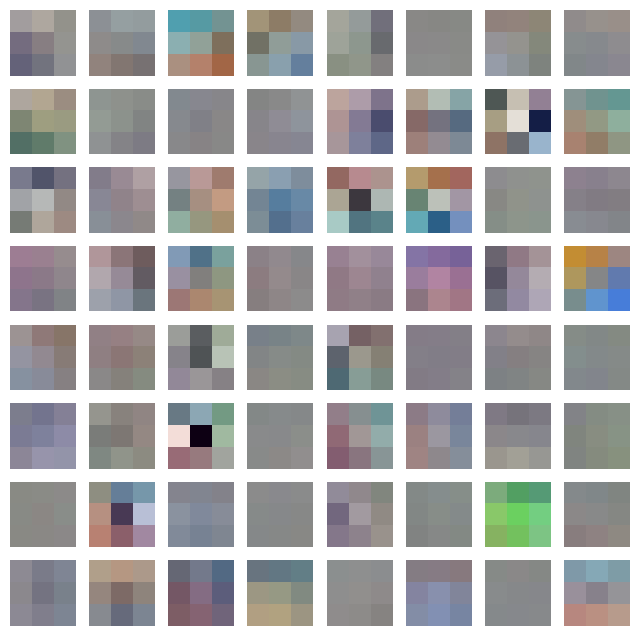

In [3]:
def visualize_first_layer_filters(model, n_rows=8, n_cols=8, conv_layer=0):
    conv1 = model.convBlock[2*conv_layer].conv1[0] 
    weights = conv1.weight.data.cpu()     # (C_out, 3, k, k)
    w_min, w_max = weights.min(), weights.max()
    weights = (weights - w_min) / (w_max - w_min)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols, n_rows))
    for i, ax in enumerate(axes.flatten()):
        if i < weights.shape[0]:
            img = weights[i].permute(1,2,0).numpy()
            ax.imshow(img)
        ax.axis('off')
    # plt.suptitle("First-layer Filters")
    plt.show()
    
visualize_first_layer_filters(model, n_rows=8, n_cols=8, conv_layer=0)

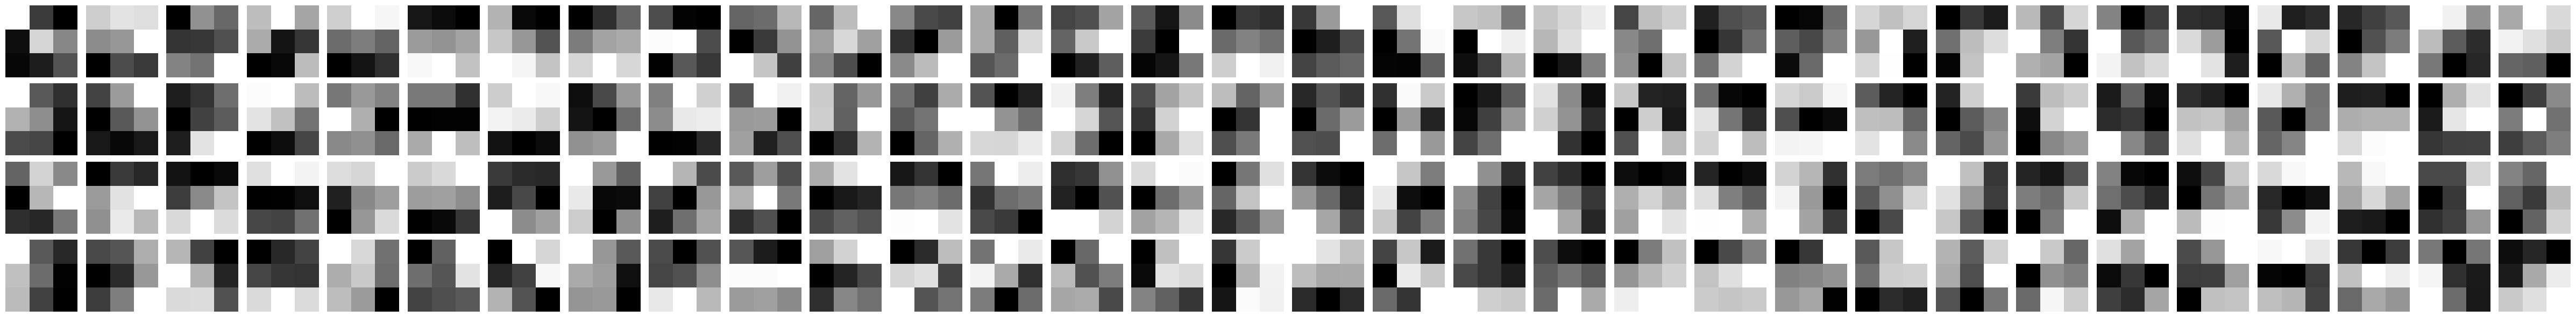

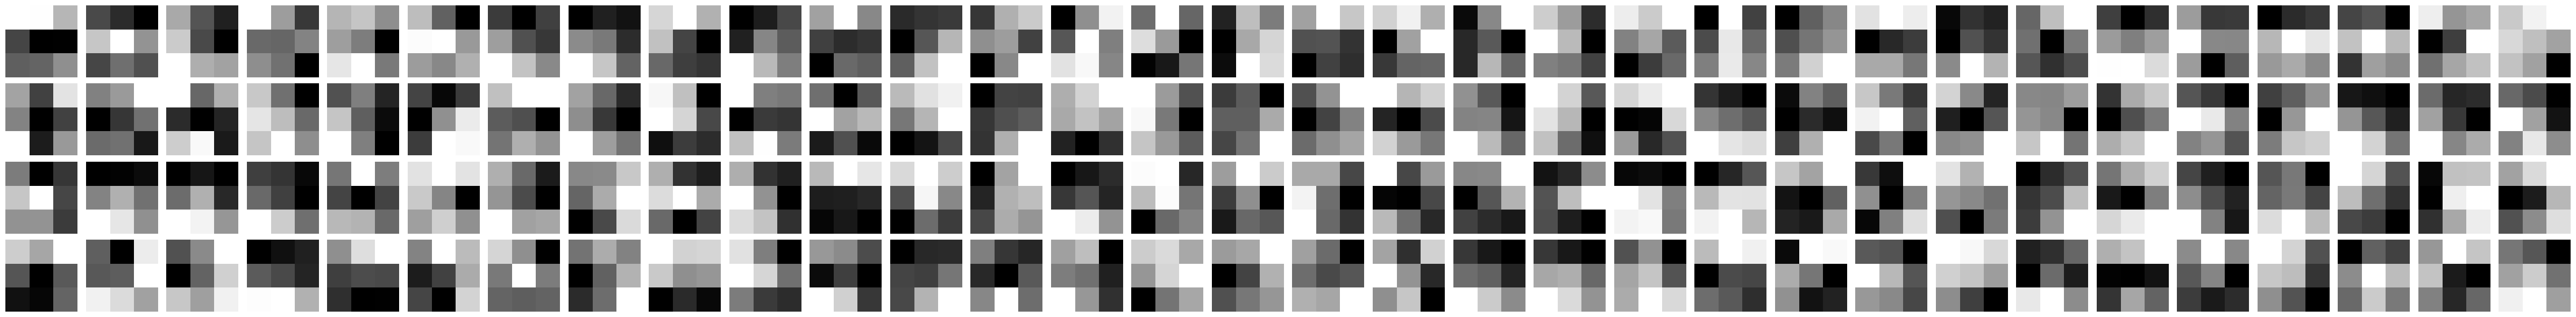

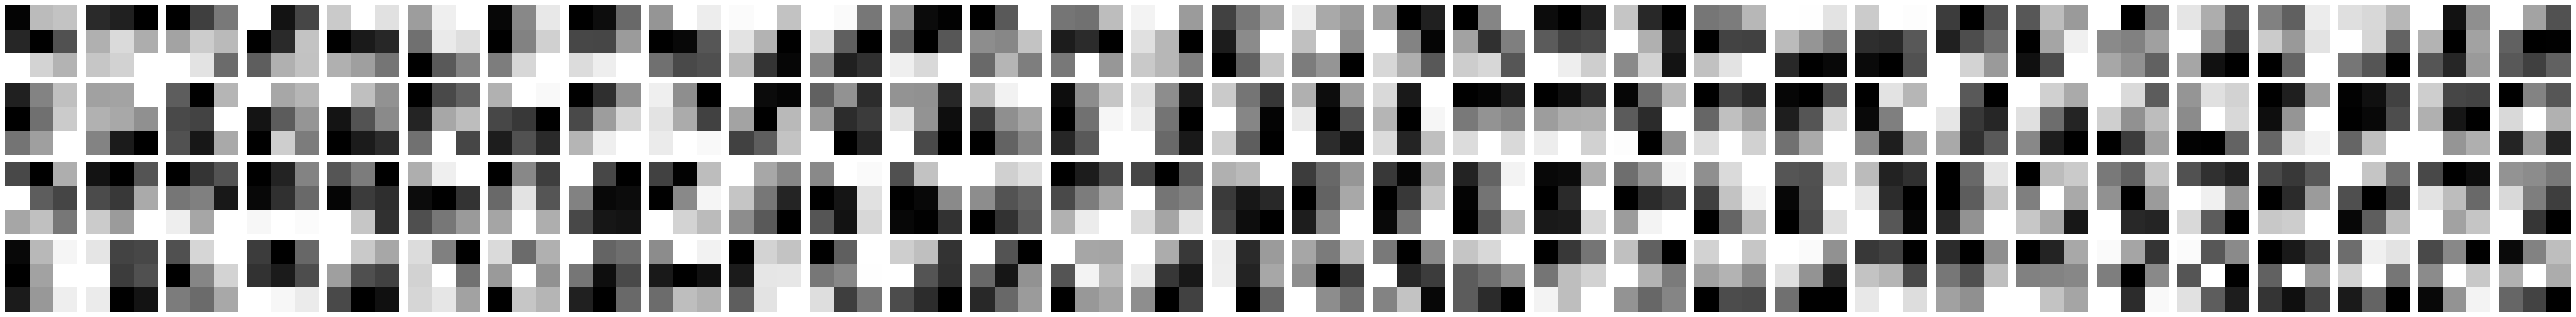

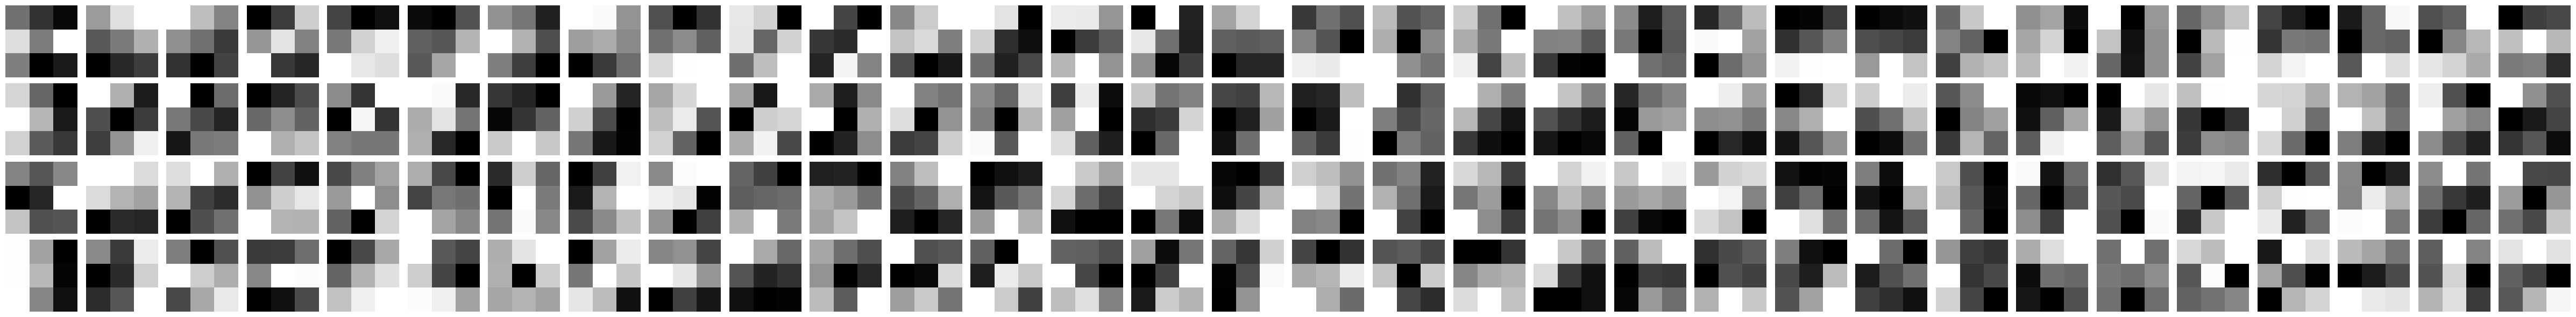

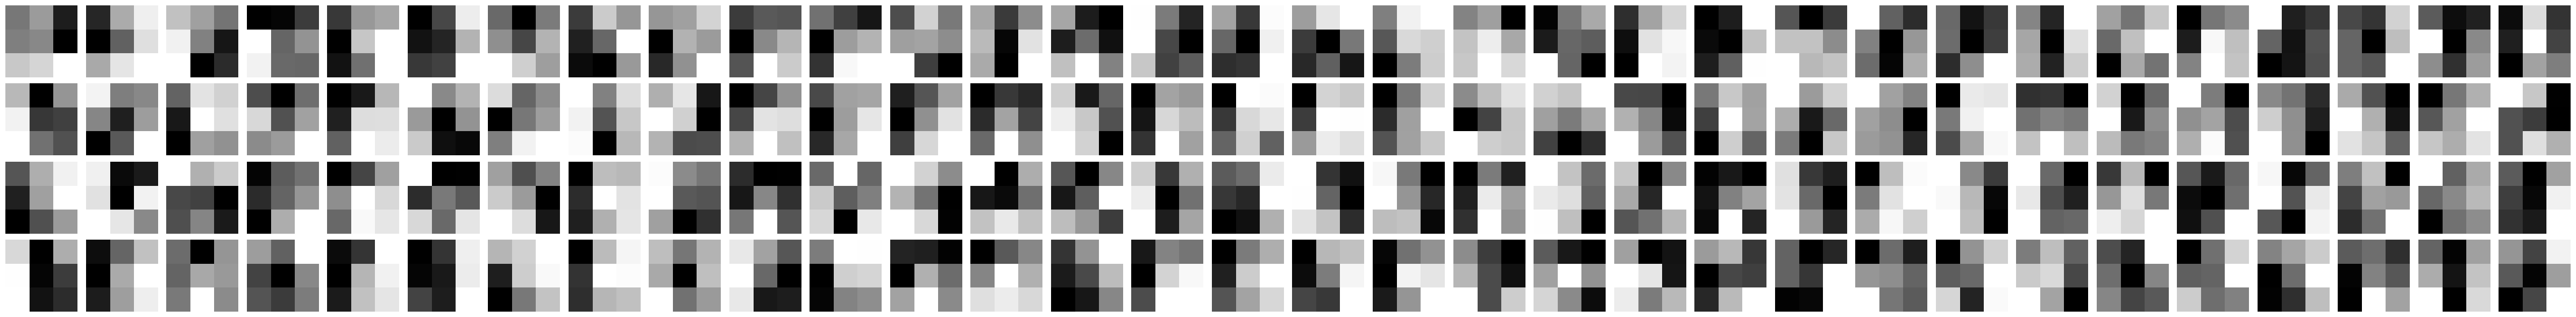

In [9]:
import matplotlib.pyplot as plt
import math
from models.myModel import convBlock as ConvBlockClass

def visualize_by_input_channel(model, conv_block_idx=0, conv_in_block=1, n_cols=8):
    """
    按输入通道分图展示某个 convBlock 中 conv1/conv2 的所有滤波器权重。
    """
    conv_blocks = [m for m in model.convBlock if isinstance(m, ConvBlockClass)]
    block = conv_blocks[conv_block_idx]
    seq = block.conv1 if conv_in_block == 1 else block.conv2
    conv = seq[0]
    
    W = conv.weight.data.cpu()
    out_c, in_c, k, _ = W.shape
    
    # print(in_c)
    # for c in range(in_c):
    for c in range(5):
        n_rows = math.ceil(out_c / n_cols)
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*1.5, n_rows*1.5))
        axes = axes.flatten()
        
        w = W[:, c, :, :]  # (out_c, k, k)
        w_min, w_max = w.min(), w.max()
        w = (w - w_min) / (w_max - w_min)
        
        for i in range(out_c):
            axes[i].imshow(w[i].numpy(), cmap='gray', interpolation='nearest')
            axes[i].axis('off')
        for ax in axes[out_c:]:
            ax.axis('off')
        
        # plt.suptitle(f"convBlock[{conv_block_idx}].conv{conv_in_block} — Channel {c}")
        plt.tight_layout()
        plt.show()

visualize_by_input_channel(model, conv_block_idx=0, conv_in_block=2, n_cols=32)

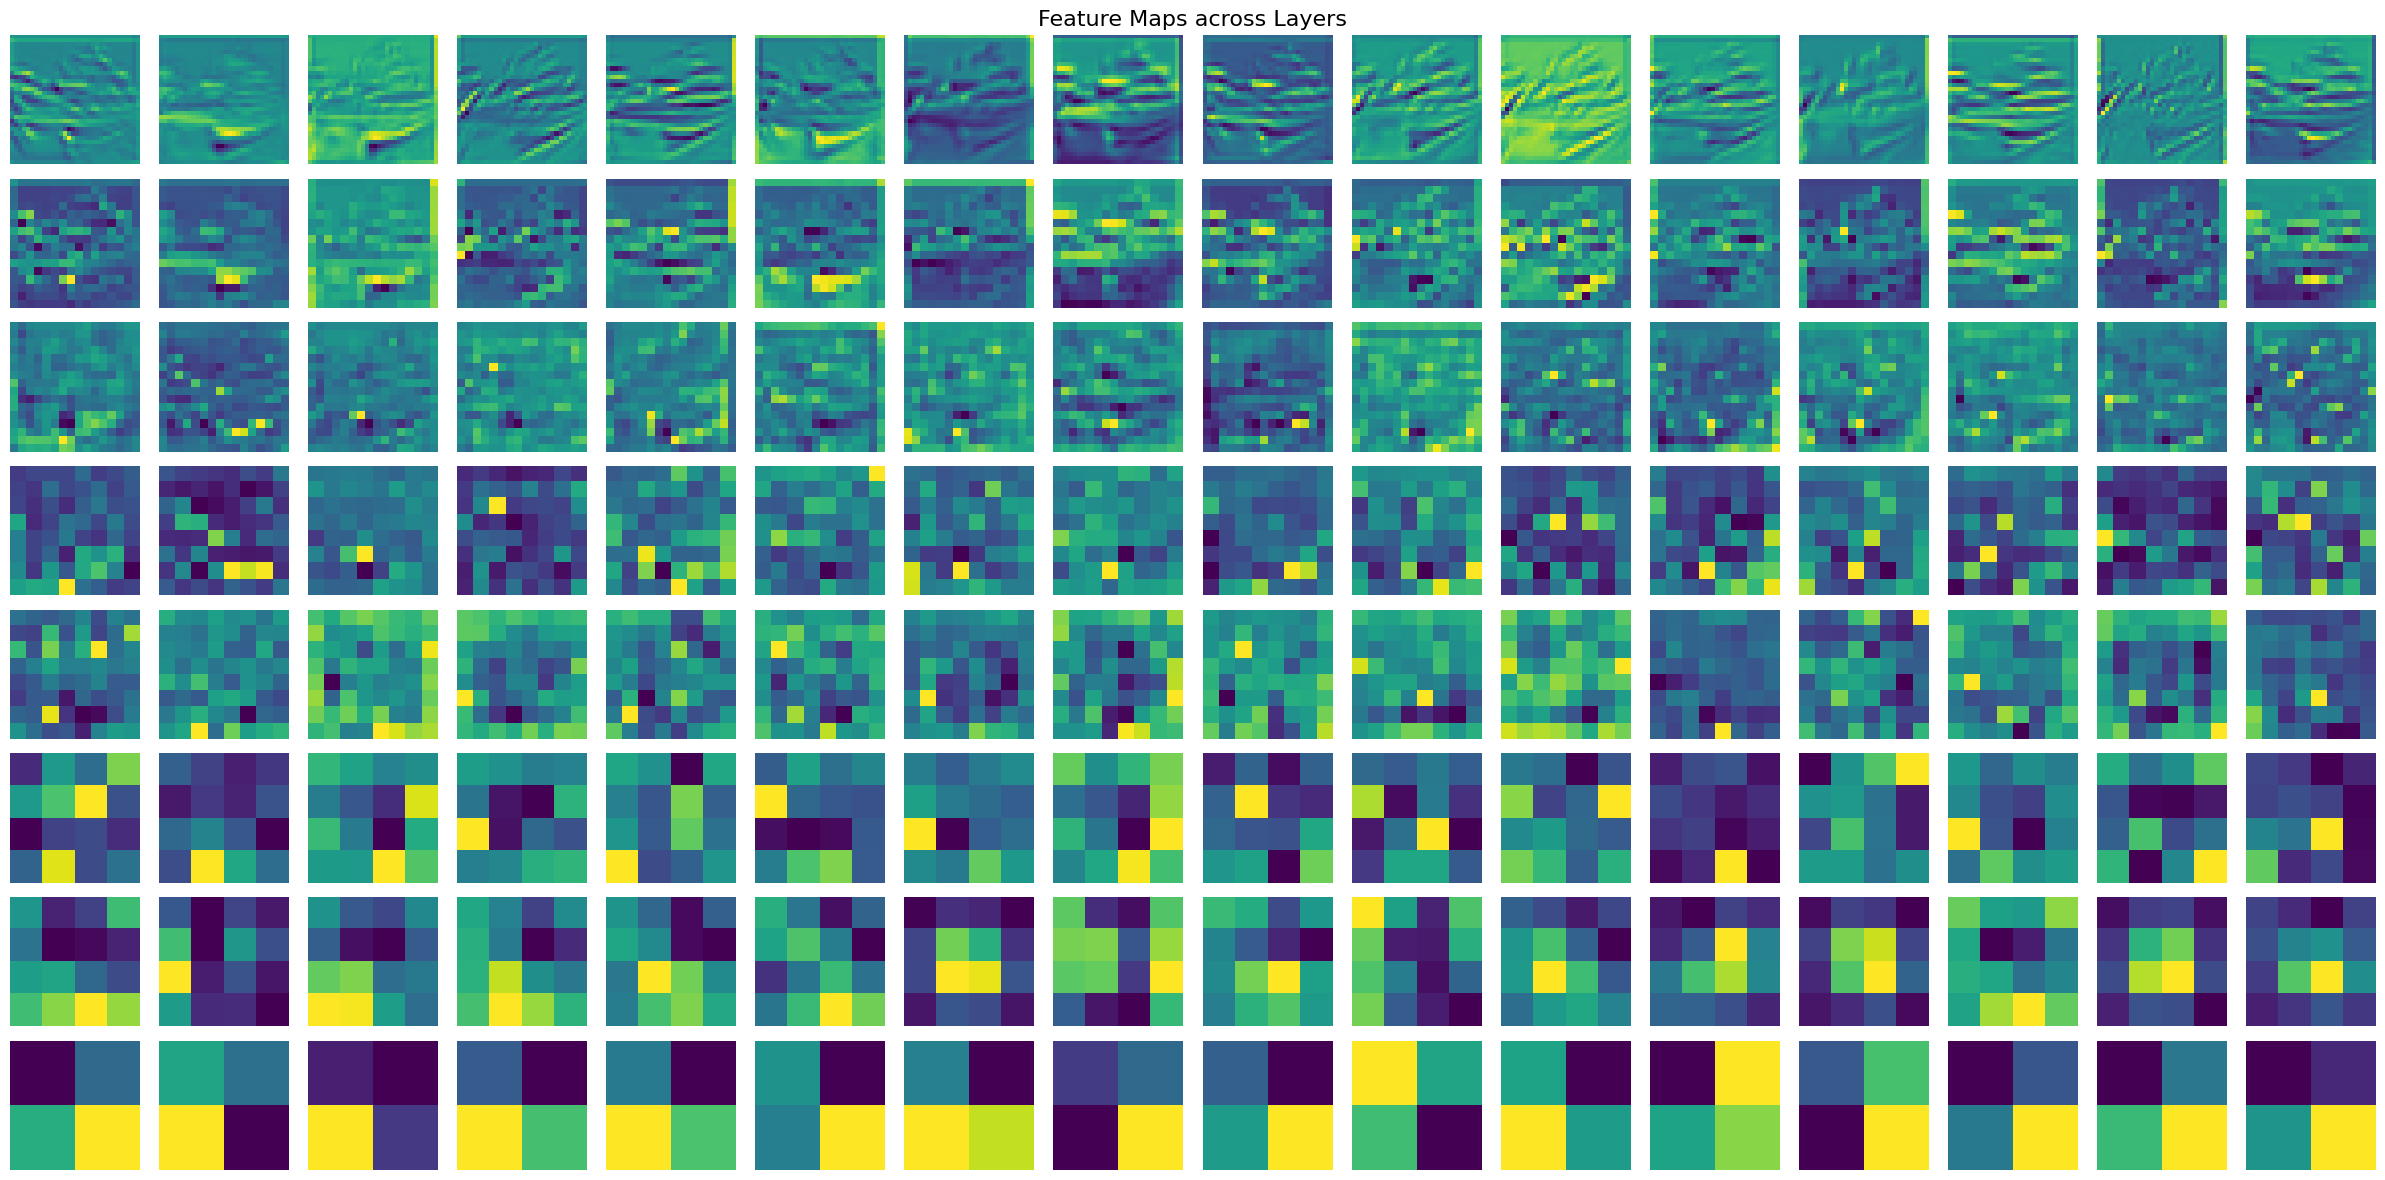

In [5]:
def visualize_feature_maps_all_in_one(model, x, layer_indices=range(8), max_maps=16):
    """
    将多个 convBlock 层的 feature map 可视化在一张图上，每层一行，最多显示 max_maps 个通道。
    """
    fig, axes = plt.subplots(len(layer_indices), max_maps, figsize=(max_maps*1.5, len(layer_indices)*1.5))
    
    if len(layer_indices) == 1:
        axes = [axes]
    model.eval()
    
    for row, layer_idx in enumerate(layer_indices):
        fmap = None
        def hook_fn(module, inp, out):
            nonlocal fmap
            fmap = out.detach().cpu()

        hook = model.convBlock[layer_idx].register_forward_hook(hook_fn)
        _ = model(x.to(next(model.parameters()).device))
        hook.remove()
        
        C = fmap.shape[1]
        n = min(C, max_maps)
        for i in range(max_maps):
            ax = axes[row][i] if len(layer_indices) > 1 else axes[0][i]
            if i < n:
                ax.imshow(fmap[0, i], cmap='viridis')
            ax.axis('off')
        
        if max_maps > 0:
            ax = axes[row][0] if len(layer_indices) > 1 else axes[0][0]
            ax.set_ylabel(f"Layer {layer_idx}", rotation=90, fontsize=10)

    plt.suptitle("Feature Maps across Layers", fontsize=16)
    plt.tight_layout()
    plt.show()

img, label = test_dataset[1]
if isinstance(img, torch.Tensor):
    x = img.unsqueeze(0).to(device)
else:
    x = transforms.ToTensor()(img).unsqueeze(0).to(device)

visualize_feature_maps_all_in_one(model, x, layer_indices=range(8), max_maps=16)

Files already downloaded and verified
Files already downloaded and verified


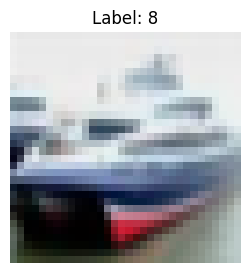

In [4]:
from utils.get_dataset import get_origin_dataset
train_origin_dataset, test_origin_dataset = get_origin_dataset()

img, label = test_origin_dataset[1]
img_show = img.permute(1, 2, 0).cpu().numpy()  # C,H,W -> H,W,C

plt.figure(figsize=(3, 3))
plt.imshow(img_show)
plt.title(f"Label: {label}")
plt.axis('off')
plt.show()

0 convBlock.0.conv1.0
1 convBlock.2.conv1.0
2 convBlock.4.conv1.0
3 convBlock.6.conv1.0


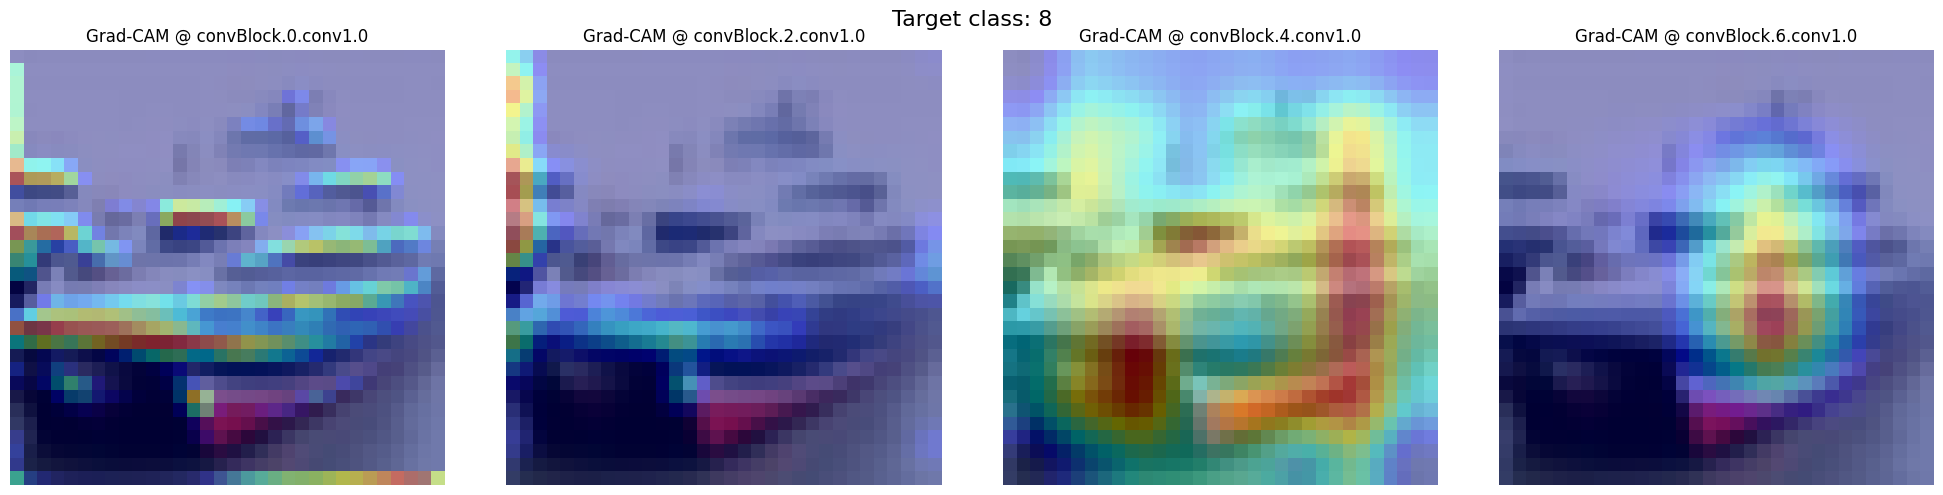

In [12]:
img, label = test_origin_dataset[1]
x = img.unsqueeze(0).to(device)         # 模型输入
orig_img = img                          # 用于叠加展示（[C, H, W]）

def grad_cam(model, x, target_class, layer_name):
    fmap, grad = None, None

    def fmap_hook(m, inp, out):
        nonlocal fmap
        fmap = out.detach()

    def grad_hook(m, grad_in, grad_out):
        nonlocal grad
        grad = grad_out[0].detach()

    for name, module in model.named_modules():
        if name == layer_name:
            module.register_forward_hook(fmap_hook)
            module.register_backward_hook(grad_hook)

    model.zero_grad()
    logits = model(x)
    logits[0, target_class].backward()

    weights = grad.mean(dim=(2, 3), keepdim=True)
    cam = (weights * fmap).sum(dim=1, keepdim=True).relu()
    cam = cam / (cam.max() + 1e-8)
    cam = cam.squeeze().cpu().numpy()
    cam = cv2.resize(cam, (x.shape[2], x.shape[3]))
    return cam

def show_grad_cam_overlays(model, x, target_class, layer_names, orig_img):
    plt.figure(figsize=(5 * len(layer_names), 5))

    for i, layer_name in enumerate(layer_names):
        # print(i, layer_name)
        cam = grad_cam(model, x, target_class, layer_name)
        heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)

        orig = np.uint8(255 * orig_img.permute(1, 2, 0).cpu().numpy())
        orig = cv2.cvtColor(orig, cv2.COLOR_RGB2BGR)

        overlay = np.uint8(0.4 * heatmap + 0.6 * orig)

        plt.subplot(1, len(layer_names), i + 1)
        plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
        plt.title(f"Grad-CAM @ {layer_name}")
        plt.axis('off')

    plt.suptitle(f"Target class: {target_class}", fontsize=16)
    plt.tight_layout()
    plt.show()

layer_names = [
    'convBlock.0.conv1.0',
    'convBlock.2.conv1.0',
    'convBlock.4.conv1.0',
    'convBlock.6.conv1.0'
]

show_grad_cam_overlays(model, x, target_class=label, layer_names=layer_names, orig_img=orig_img)